<a href="https://colab.research.google.com/github/amikoshimrah/sothingshimrah/blob/main/Project_SVH_Digit_Recognition_Neural_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project -Neural Network
#### Street View Housing Number Digit Recognition

#### The Problem Description:
Recognizing multi-digit numbers in photographs captured at street level is an important component of modernday map making. A classic example of a corpus of such street-level photographs is Google’s Street View
imagery comprised of hundreds of millions of geo-located 360-degree panoramic images. The ability to
automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed
number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building
it represents. More broadly, recognizing numbers in photographs is a problem of interest to the optical
character recognition community. While OCR on constrained domains like document processing is well
studied, arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises
due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts,
colours, styles, orientations, and character arrangements. The recognition problem is further complicated by
environmental factors such as lighting, shadows, specularities, and occlusions as well as by image acquisition
factors such as resolution, motion, and focus blurs. In this project, we will use the dataset with images centred
around a single digit (many of the images do contain some distractors at the sides). Although we are taking a
sample of the data which is simpler, it is more complex than MNIST because of the distractors.

#### Dataset
SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with the
minimal requirement on data formatting but comes from a significantly harder, unsolved, real-world problem
(recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google
Street View images.

#### Import Libraries and Load Data

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Activation,Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import math
import numpy as np
np.random.seed(1)
tf.random.set_seed(2)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
tf.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import h5py
#df = h5py.File('SVHN_single_grey1.h5','r')
df = h5py.File('/content/drive/My Drive/SVHN_single_grey1.h5','r')
df.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

### Getting details of dataset
- We will see how many rows are there in the data

In [ ]:
X_train = df['X_train'][:]
y_train = df['y_train'][:]
X_test = df['X_test'][:]
y_test = df['y_test'][:]
X_val = df['X_val'][:]
y_val = df['y_val'][:]
print(f'Shape of X_train:{X_train.shape}')
print(f'Shape of y_train:{y_train.shape}')
print(f'Shape of X_test:{X_test.shape}')
print(f'Shape of y_test:{y_test.shape}')

Shape of X_train:(42000, 32, 32)
Shape of y_train:(42000,)
Shape of X_test:(18000, 32, 32)
Shape of y_test:(18000,)


In [ ]:
y_test.view()

array([1, 7, 2, ..., 7, 9, 2], dtype=uint8)

### Visualize the data
Plot first 10 images in the triaining set and their labels.

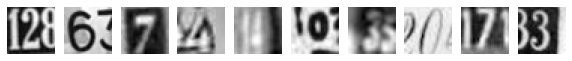

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [ ]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32,32), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[:10]))

## Data Pre-processing
### 1. Reshape features
- reshape() method gives a new shape to an array without changing its data

In [ ]:
X_train = X_train.reshape(X_train.shape[0],1024, 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],1024, 1)
print(X_test.shape)

(42000, 1024, 1)
(18000, 1024, 1)



### 2. Normalize features
- Normalize features from 0-255 to 0-1

In [ ]:
print(X_train.max())
print(X_train.min())

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

#X_train = tf.keras.utils.normalize(X_train,axis=1)
#X_test = tf.keras.utils.normalize(X_test,axis=1)
print(X_train.max())
print(X_train.min())

254.9745
0.0
0.9999
0.0


### 3. Convert both training and testing labels into one-hot vectors.
- convert class vectors (integers) to binary class matrix
- convert y_train and y_test
- number of classes: 10

In [ ]:
print(y_train[10])
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(y_train[10])

1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


Expected output should look like

In [ ]:
print(y_train.shape)
print('  First 10 examples now are: \n', y_train[0:10])

(42000, 10)
  First 10 examples now are: 
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Building Model with a cross entropy loss function and  optimizer in Keras
## 1. Basic NN model for the output layer with 10 neurons as we have 10 classes.

Naive MLP model without any alterations

Let's build vanilla model activation as sigmoid and optimizer as adam

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
#Initialize sequenial model
model = Sequential()
#Add Dense Layer which provides hidden neurons
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(256,activation ='sigmoid'))
model.add(Dense(128,activation ='sigmoid'))
model.add(Dense(64,activation ='sigmoid'))
model.add(Dense(32,activation ='sigmoid'))
#Add Dense layer which provides 10 outputs after applying softmax
model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam()
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=128, verbose= 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,0.595542,0.812500
Test,0.737677,0.774222


#### We saw the good accuracy  .
lets try other advance technique as well

## 2. Advanced techniques for training neural networks
### Let's try out all the techniques
### 2.1. Weight Initialization
Changing weight initialization scheme can significantly improve training of the model by preventing vanishing gradient problem up to some degree

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
#Initialize sequenial model
model = Sequential()
#Add Dense Layer which provides hidden neurons
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(256,activation ='sigmoid',kernel_initializer='he_normal')) # Weight initialization with He_normal
model.add(Dense(128,activation ='sigmoid',kernel_initializer='he_normal'))
model.add(Dense(64,activation ='sigmoid',kernel_initializer='he_normal'))
model.add(Dense(32,activation ='sigmoid',kernel_initializer='he_normal'))
#Add Dense layer which provides 10 outputs after applying softmax
model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam()
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=128, verbose= 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,0.596405,0.809405
Test,0.754721,0.767056


There is slight decline after Weight initialisation

### 2.2. Nonlinearity (Activation function)

Sigmoid functions suffer from gradient vanishing problem, making training slower

There are many choices apart from sigmoid and tanh.'relu' (rectified linear unit) is one of the most popular ones

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
#Initialize sequenial model
model = Sequential()
#Add Dense Layer which provides hidden neurons
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(256,activation ='relu',kernel_initializer='he_normal'))
model.add(Dense(128,activation ='relu',kernel_initializer='he_normal'))
model.add(Dense(64,activation ='relu',kernel_initializer='he_normal'))
model.add(Dense(32,activation ='relu',kernel_initializer='he_normal'))
#Add Dense layer which provides 10 outputs after applying softmax
model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam()
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=128, verbose= 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,0.408672,0.869619
Test,0.673165,0.810944


#### Accuracy is improve after activation changed to relu.

### 2.3.  Batch Normalization
Batch Normalization, one of the methods to prevent the "internal covariance shift" problem, has proven to be highly effective

Normalize each mini-batch before nonlinearity

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
#Initialize sequenial model
model = Sequential()
#Add Dense Layer which provides hidden neurons
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(256,activation ='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(128,activation ='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(64,activation ='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(32,activation ='relu',kernel_initializer='he_normal'))
#Add Dense layer which provides 10 outputs after applying softmax
model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam()
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=128, verbose= 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,0.593493,0.81381
Test,0.844679,0.76500


### 2.4. Dropout

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
#Initialize sequenial model
model = Sequential()
#Add Dense Layer which provides hidden neurons
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(256,activation ='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(128,activation ='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(64,activation ='relu',kernel_initializer='he_normal'))
model.add(Dense(32,activation ='relu',kernel_initializer='he_normal'))
#Add Dense layer which provides 10 outputs after applying softmax
model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam()
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=128,verbose= 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,0.545705,0.828238
Test,0.661044,0.795889


## 3. Hyper Parameter Tuning
- We saw that 2.2. Nonlinearity (Activation function) has good accuracy. I would like the perform the the hyper parameter tuning

### Creating model 1



In [ ]:
def model_nn(iterations,lr,Lambda, verb=True):
    np.random.seed(1)
    tf.random.set_seed(2)
    ## hyperparameters
    iterations = iterations
    learning_rate = lr

    model = Sequential()
    model.add(Flatten(input_shape=X_train[0].shape))
    model.add(Dense(256, kernel_initializer='he_uniform', activation='relu')) ###Multiple Dense units with Relu activation
    model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(64, kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(32, kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(Lambda)))

    # Compile model
    adam = optimizers.Adam(lr=learning_rate, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

### Creating model 2
- Same model as above
- Instead of accuracy at each epoch below code gives the consolidate accuracy
- Notice: The model.evaluate line at the last is the only difference from model 1

In [ ]:
def train_and_test_loop1(iterations, lr,Lambda, verb=True):

    ## hyperparameters
    iterations = iterations
    learning_rate = lr

    model = Sequential()
    model.add(Flatten(input_shape=X_train[0].shape))
    model.add(Dense(256, kernel_initializer='he_normal', activation='relu')) ###Multiple Dense units with Relu activation
    model.add(Dense(128, kernel_initializer='he_normal',activation='relu'))
    model.add(Dense(64, kernel_initializer='he_normal',activation='relu'))
    model.add(Dense(32, kernel_initializer='he_normal',activation='relu'))
    model.add(Dense(10, activation='softmax',kernel_regularizer=regularizers.l2(Lambda)))

    # Compile model
    adam = optimizers.Adam(lr=learning_rate, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=50, batch_size=128,validation_data=(X_test, y_test), verbose= 2)

    score = model.evaluate(X_train, y_train)
    return score

### Next steps
- Double Check that the loss is reasonable
- Disable the regularization (Lambda = 0)

In [ ]:
lr = 0.00001
Lambda = 0
iterations = 1
model = model_nn(iterations,lr,Lambda)
model.fit(X_train, y_train, epochs = iterations,batch_size=128 , verbose = 1);

329/329 [==============================] - 2s 7ms/step - loss: 2.3119 - accuracy: 0.1196


### Validation
- There are 10 output classes and the model is correctly predicting 1 up on 10 times (1/10 = 0.1% approx) as it is untrained.

In [ ]:
lr = 1e1
Lambda =1e-5
iterations = 1
model = model_nn(iterations,lr,Lambda)
model.fit(X_train, y_train, epochs = iterations,batch_size=128 , verbose = 1);

329/329 [==============================] - 2s 7ms/step - loss: 34235803648.0000 - accuracy: 0.1006


loss went up. Good! (Another sanity check)

### Start with small regularization and find learning rate that makes the loss go down.

- we start with Lambda(small regularization) = 1e-5
- we start with a small learning rate = 1e-5

In [ ]:
lr = 1e-5
Lambda = 1e-5
iterations = 20
model = model_nn(iterations,lr,Lambda)
model.fit(X_train, y_train, epochs = iterations,batch_size=128 ,verbose = 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,1.589038,0.532643
Test,1.589882,0.535611


### Loss barely changing. Learning rate is probably too low.
### Okay now lets try a (larger) learning rate 1e5. What could possibly go wrong?

- Learning rate lr = 1e5
- Regularization lambda = 1e-5

In [ ]:
lr = 1e5
Lambda = 1e-5
iterations = 20
model = model_nn(iterations,lr,Lambda)
model.fit(X_train, y_train, epochs = iterations,batch_size=128 ,verbose = 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,NaN,0.099667
Test,NaN,0.100778


### Loss is exploding.Learning rate is too high.
### Cost is very high. Always means high learning rate
### Lets try to train now with a value of learning rate between 1e1 and 1e-4

- learning rate = 1e1
- regularization remains the small, lambda = 1e-5

In [ ]:
lr = 1e1
Lambda = 1e-5
iterations = 20
model = model_nn(iterations,lr,Lambda)
model.fit(X_train, y_train, epochs = iterations,batch_size=128 , verbose = 0);

In [ ]:
#Check the final out come of the model
train = model.evaluate(X_train, y_train, verbose=0)
test = model.evaluate(X_test, y_test, verbose=0)
results = pd.DataFrame({'Train':train,'Test':test}).T
results.columns=['Loss','Accuracy']
results

,Loss,Accuracy
Train,11.978251,0.100762
Test,11.979209,0.098222


### Still too high learning rate. Loss is not decreasing. The rough range of learning rate we should be cross validating is somewhere between [1e-1 to 1e-5]
### Hyperparameter Optimization

### Cross validation Strategy


- Do coarse -> fine cross-validation in stages

- First stage: only a few epochs to get rough idea of what params work
- Second stage: longer running time, finer search

### For example: Run coarse search for 10 times with different lr and Lambda values each with 20 epochs.

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-5.0, -1.0))
    Lambda = math.pow(10, np.random.uniform(-4,-1))
    best_acc = train_and_test_loop1(50, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 10, best_acc, lr, Lambda))

Epoch 1/50
329/329 - 2s - loss: 2.3438 - accuracy: 0.1936 - val_loss: 2.0452 - val_accuracy: 0.2932
Epoch 2/50
329/329 - 2s - loss: 1.7985 - accuracy: 0.4019 - val_loss: 1.6546 - val_accuracy: 0.4638
Epoch 3/50
329/329 - 3s - loss: 1.5560 - accuracy: 0.5104 - val_loss: 1.5236 - val_accuracy: 0.5352
Epoch 4/50
329/329 - 2s - loss: 1.3933 - accuracy: 0.5786 - val_loss: 1.3048 - val_accuracy: 0.6152
Epoch 5/50
329/329 - 2s - loss: 1.2733 - accuracy: 0.6237 - val_loss: 1.3256 - val_accuracy: 0.5937
Epoch 6/50
329/329 - 3s - loss: 1.1975 - accuracy: 0.6501 - val_loss: 1.1401 - val_accuracy: 0.6731
Epoch 7/50
329/329 - 2s - loss: 1.1261 - accuracy: 0.6750 - val_loss: 1.1184 - val_accuracy: 0.6761
Epoch 8/50
329/329 - 3s - loss: 1.0603 - accuracy: 0.6955 - val_loss: 1.0762 - val_accuracy: 0.6876
Epoch 9/50
329/329 - 2s - loss: 1.0204 - accuracy: 0.7070 - val_loss: 1.0499 - val_accuracy: 0.7001
Epoch 10/50
329/329 - 2s - loss: 0.9820 - accuracy: 0.7202 - val_loss: 0.9516 - val_accuracy: 0.7344

### As you can see from above, Case 1, 5 and 9 yields good accuracy. It is better to focus on those values for learning rate and Lambda

### Now run finer search

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-4.0, -3.0))
    Lambda = math.pow(10, np.random.uniform(-4,-2))
    best_acc = train_and_test_loop1(50, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 10, best_acc, lr, Lambda))

Epoch 1/50
329/329 - 2s - loss: 2.2207 - accuracy: 0.2105 - val_loss: 1.9634 - val_accuracy: 0.3440
Epoch 2/50
329/329 - 3s - loss: 1.6909 - accuracy: 0.4510 - val_loss: 1.5074 - val_accuracy: 0.5226
Epoch 3/50
329/329 - 3s - loss: 1.4212 - accuracy: 0.5629 - val_loss: 1.3824 - val_accuracy: 0.5741
Epoch 4/50
329/329 - 2s - loss: 1.2814 - accuracy: 0.6191 - val_loss: 1.1978 - val_accuracy: 0.6474
Epoch 5/50
329/329 - 2s - loss: 1.1779 - accuracy: 0.6556 - val_loss: 1.1631 - val_accuracy: 0.6579
Epoch 6/50
329/329 - 2s - loss: 1.1134 - accuracy: 0.6744 - val_loss: 1.0773 - val_accuracy: 0.6848
Epoch 7/50
329/329 - 2s - loss: 1.0546 - accuracy: 0.6944 - val_loss: 1.0824 - val_accuracy: 0.6829
Epoch 8/50
329/329 - 2s - loss: 1.0153 - accuracy: 0.7030 - val_loss: 1.0265 - val_accuracy: 0.6991
Epoch 9/50
329/329 - 2s - loss: 0.9820 - accuracy: 0.7150 - val_loss: 1.0362 - val_accuracy: 0.6979
Epoch 10/50
329/329 - 2s - loss: 0.9468 - accuracy: 0.7280 - val_loss: 0.9527 - val_accuracy: 0.7242

### Running deep with lr=le-4 and Lambda=1e-4

In [ ]:
lr = 1e-4
Lambda = 1e-4
iterations = 100
model = model_nn(iterations,lr,Lambda)
history = model.fit(X_train, y_train, epochs = iterations,batch_size=128,validation_data=(X_test,y_test), verbose = 2)

Epoch 1/100
329/329 - 3s - loss: 2.2264 - accuracy: 0.1867 - val_loss: 2.0457 - val_accuracy: 0.3151
Epoch 2/100
329/329 - 3s - loss: 1.8452 - accuracy: 0.3932 - val_loss: 1.6337 - val_accuracy: 0.4987
Epoch 3/100
329/329 - 3s - loss: 1.5272 - accuracy: 0.5334 - val_loss: 1.4110 - val_accuracy: 0.5801
Epoch 4/100
329/329 - 3s - loss: 1.3492 - accuracy: 0.5956 - val_loss: 1.2868 - val_accuracy: 0.6195
Epoch 5/100
329/329 - 2s - loss: 1.2391 - accuracy: 0.6299 - val_loss: 1.2053 - val_accuracy: 0.6462
Epoch 6/100
329/329 - 3s - loss: 1.1594 - accuracy: 0.6572 - val_loss: 1.1330 - val_accuracy: 0.6627
Epoch 7/100
329/329 - 2s - loss: 1.1033 - accuracy: 0.6721 - val_loss: 1.0763 - val_accuracy: 0.6826
Epoch 8/100
329/329 - 2s - loss: 1.0553 - accuracy: 0.6882 - val_loss: 1.0530 - val_accuracy: 0.6826
Epoch 9/100
329/329 - 3s - loss: 1.0164 - accuracy: 0.6972 - val_loss: 1.0356 - val_accuracy: 0.6856
Epoch 10/100
329/329 - 3s - loss: 0.9837 - accuracy: 0.7077 - val_loss: 0.9839 - val_accura

## Review Model

In [ ]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_140 (Dense)            (None, 256)               262400    
_________________________________________________________________
dense_141 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_142 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_143 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_144 (Dense)            (None, 10)                330       
Total params: 347,050
Trainable params: 347,050
Non-trainable params: 0
_______________________________________________

### Cross-checking the prediction

Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


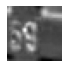

In [ ]:
plt.figure(figsize=(10,1))
print("Label: {}".format(y_test[704]))
plt.imshow(X_test[704].reshape(32,32), cmap='gray')
plt.axis('off');

In [ ]:
res_test = model.predict(X_test)
res_test = pd.DataFrame({'Actual label':np.argmax(y_test, axis=1),
                         'Predicted':np.argmax(res_test, axis=1),
                         'Correctly Predicted %':np.max(res_test, axis=1)*100})
res_test.head(10)

,Actual label,Predicted,Correctly Predicted %
0,1,1,32.727093
1,7,7,93.193680
2,2,2,99.905983
3,9,9,99.999710
4,0,0,99.997375
5,9,9,99.958984
6,1,1,99.171547
7,8,8,44.189598
8,4,1,99.936691
9,4,4,99.994934


## Conclusion and Interpretation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Loss:", scores[0])
print("Accuracy:", scores[1])

Loss: 0.6266974806785583
Accuracy: 0.8341110944747925


Text(0.5, 1.0, 'Training and validation loss')

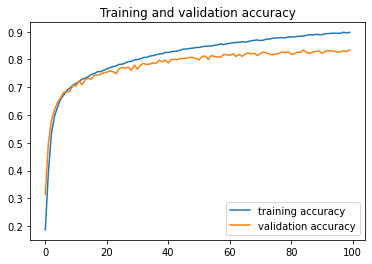

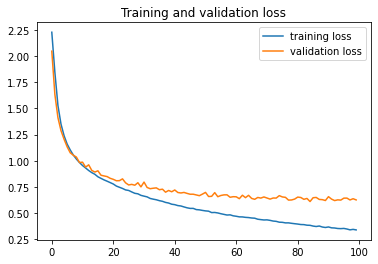

In [ ]:
accuracy      = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss'   )

There are around 10 classes in the dataset which represent digits from 0-9.

We tried training a Neural Network with dense hidden layers of different number of units and are able to achieve a final test accuracy of 83.41 %.

Also we notice that after a certain point the model begins to overfit on our dataset as is clear from the plots above where the validation loss begins to increase after certain point and validation accuracy begins to decrease.

Thus, with this amount of accuracy we are able to distinguish between the different digits in this dataset.

### Additional hyperparameter check
Just wanted to check 'for the above observed learning rate and l2 regularization values'.
Is there a better Weight regularization option - using grid search and KerasClassifier

In [ ]:
# let's create a function that creates the model (required for KerasClassifier)
# while accepting the hyperparameters we want to tune
# we also pass some default values such as optimizer=Adam

# Compile model

def create_model(init_mode,lr,Lambda, verb=True):
    np.random.seed(1)
    tf.random.set_seed(2)
    # define model
    model = Sequential()
    model.add(Flatten(input_shape=X_train[0].shape))
    model.add(Dense(256 , kernel_initializer=init_mode, activation='relu')) ###Multiple Dense units with Relu activation
    model.add(Dense(128 , kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(64 , kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(32 , kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(10 , activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    adam = optimizers.Adam(lr=lr, decay=1e-6)
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
    return model

In [ ]:
%%time

batch_size = 128
epochs = 100
model_CV = KerasClassifier(build_fn=create_model, epochs=epochs,
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero',
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

lr = [math.pow(10, np.random.uniform(-4.0, -4.0))]
Lambda = [math.pow(10, np.random.uniform(-4,-4))]
param_grid = dict(init_mode=init_mode ,lr=lr ,Lambda=Lambda)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train , validation_data=(X_test, y_test))

Epoch 1/100
329/329 - 2s - loss: 2.2382 - accuracy: 0.1864 - val_loss: 2.1040 - val_accuracy: 0.2859
Epoch 2/100
329/329 - 2s - loss: 1.9254 - accuracy: 0.3512 - val_loss: 1.7418 - val_accuracy: 0.4314
Epoch 3/100
329/329 - 2s - loss: 1.6464 - accuracy: 0.4532 - val_loss: 1.5494 - val_accuracy: 0.5109
Epoch 4/100
329/329 - 2s - loss: 1.4810 - accuracy: 0.5294 - val_loss: 1.4055 - val_accuracy: 0.5656
Epoch 5/100
329/329 - 2s - loss: 1.3729 - accuracy: 0.5750 - val_loss: 1.3335 - val_accuracy: 0.5883
Epoch 6/100
329/329 - 2s - loss: 1.2832 - accuracy: 0.6114 - val_loss: 1.2476 - val_accuracy: 0.6292
Epoch 7/100
329/329 - 2s - loss: 1.2108 - accuracy: 0.6352 - val_loss: 1.1880 - val_accuracy: 0.6429
Epoch 8/100
329/329 - 2s - loss: 1.1485 - accuracy: 0.6572 - val_loss: 1.1356 - val_accuracy: 0.6623
Epoch 9/100
329/329 - 2s - loss: 1.1015 - accuracy: 0.6703 - val_loss: 1.1288 - val_accuracy: 0.6542
Epoch 10/100
329/329 - 2s - loss: 1.0571 - accuracy: 0.6848 - val_loss: 1.0648 - val_accura

In [ ]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.8032142917315165 using {'Lambda': 0.0001, 'init_mode': 'he_uniform', 'lr': 0.0001}
 mean=0.7454, std=0.007884 using {'Lambda': 0.0001, 'init_mode': 'uniform', 'lr': 0.0001}
 mean=0.7993, std=0.005469 using {'Lambda': 0.0001, 'init_mode': 'lecun_uniform', 'lr': 0.0001}
 mean=0.777, std=0.002403 using {'Lambda': 0.0001, 'init_mode': 'normal', 'lr': 0.0001}
 mean=0.09774, std=0.001852 using {'Lambda': 0.0001, 'init_mode': 'zero', 'lr': 0.0001}
 mean=0.794, std=0.003252 using {'Lambda': 0.0001, 'init_mode': 'glorot_normal', 'lr': 0.0001}
 mean=0.8019, std=0.001419 using {'Lambda': 0.0001, 'init_mode': 'glorot_uniform', 'lr': 0.0001}
 mean=0.7949, std=0.001258 using {'Lambda': 0.0001, 'init_mode': 'he_normal', 'lr': 0.0001}
 mean=0.8032, std=0.001012 using {'Lambda': 0.0001, 'init_mode': 'he_uniform', 'lr': 0.0001}


In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Loss:", scores[0])
print("Accuracy:", scores[1])

Loss: 0.6266974806785583
Accuracy: 0.8341110944747925
